In [1]:
# Clean imports with warning suppression
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'

import tensorflow_hub as hub
import tensorflow as tf
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf

# Suppress all TensorFlow warnings
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
PROJECT_ROOT = Path("/Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154")
manifests_dir = PROJECT_ROOT / "Manifests"
train_csv = manifests_dir / "train.csv"
val_csv   = manifests_dir / "val.csv"
test_csv  = manifests_dir / "test.csv"

FAMILY_COLNAME = "family_label"
SAMPLE_RATE = 16000  # YAMNet expects 16kHz
DURATION_SECONDS = 3  # YAMNet works well with 3-second clips
TARGET_NUM_SAMPLES = SAMPLE_RATE * DURATION_SECONDS
BATCH_SIZE = 4  # Smaller batch size for YAMNet (feature extraction is slower)
EPOCHS = 25
LR = 1e-3  # Slightly higher LR since we're only training classifier head
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print("Using device:", DEVICE)
print(f"YAMNet configuration: {SAMPLE_RATE}Hz, {DURATION_SECONDS}s clips")

Using device: mps
YAMNet configuration: 16000Hz, 3s clips


In [ ]:
class Normalize:
    def __call__(self, x: torch.Tensor):
        x = x / (x.abs().max() + 1e-9)
        rms = x.pow(2).mean().sqrt()
        if rms > 0:
            x = x / (rms + 1e-9) * 0.1
        return x

class YAMNetDataset(Dataset):
    def __init__(self, csv_path, label_map):
        self.df = pd.read_csv(csv_path)
        self.label_map = label_map
        self.norm = Normalize()
        # YAMNet expects 16kHz audio, minimum 0.96 seconds
        self.target_length = TARGET_NUM_SAMPLES

    def _fix_length(self, wav: torch.Tensor, target_len: int):
        # wav shape: [channels, time]
        T = wav.shape[-1]
        if T == target_len:
            return wav
        if T > target_len:
            # Take middle section
            start = (T - target_len) // 2
            return wav[..., start:start + target_len]
        # pad with zeros
        pad_len = target_len - T
        return torch.nn.functional.pad(wav, (0, pad_len))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load raw audio for YAMNet
        wav_np, sr = sf.read(row['filepath'], dtype='float32')
        
        # Convert to torch tensor and ensure shape is [channels, time]
        wav = torch.from_numpy(wav_np)
        if wav.dim() == 1:
            wav = wav.unsqueeze(0)  # [time] -> [1, time]
        else:
            wav = wav.T  # [time, channels] -> [channels, time]
        
        # Convert to mono
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        
        # Resample if needed
        if sr != SAMPLE_RATE:
            import torchaudio.functional as F
            wav = F.resample(wav, sr, SAMPLE_RATE)
        
        # Fix length and normalize
        wav = self._fix_length(wav, self.target_length)
        wav = self.norm(wav)
        
        # YAMNet expects 1D waveform [time,]
        wav = wav.squeeze(0)  # Remove channel dimension
        
        label = self.label_map[row[FAMILY_COLNAME]]
        return wav, label

    def __len__(self):
        return len(self.df)

In [4]:
df_train = pd.read_csv(train_csv)
families = sorted(df_train[FAMILY_COLNAME].unique())
family_to_idx = {f:i for i,f in enumerate(families)}
idx_to_family = {i:f for f,i in family_to_idx.items()}
num_classes = len(family_to_idx)

print(f"Instrument families: {families}")
print(f"Number of classes: {num_classes}")

# Use YAMNet-compatible dataset
train_ds = YAMNetDataset(train_csv, family_to_idx)
val_ds   = YAMNetDataset(val_csv, family_to_idx)
test_ds  = YAMNetDataset(test_csv, family_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Batch size: {BATCH_SIZE} (optimized for YAMNet)")

# Test one sample
test_wav, test_label = train_ds[0]
print(f"Sample waveform shape: {test_wav.shape}")
print(f"Sample label: {families[test_label]} (class {test_label})")

Instrument families: ['keyboards', 'percussion', 'strings', 'voice', 'winds']
Number of classes: 5
Training samples: 579
Validation samples: 149
Test samples: 146
Batch size: 4 (optimized for YAMNet)
Sample waveform shape: torch.Size([48000])
Sample label: winds (class 4)


In [5]:
class YAMNetClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        print("Loading YAMNet...")
        self.yamnet = hub.load('https://tfhub.dev/google/yamnet/1')
        print("YAMNet loaded")
        
        # Better classifier - not too simple, not too complex
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def extract_yamnet_features(self, waveforms):
        embeddings = []
        
        for waveform in waveforms:
            waveform_np = waveform.cpu().numpy().astype(np.float32)
            
            with tf.device('/CPU:0'):
                scores, embeddings_tf, spectrogram = self.yamnet(waveform_np)
                embedding = tf.reduce_mean(embeddings_tf, axis=0)
                embeddings.append(embedding.numpy())
        
        embeddings = torch.FloatTensor(np.array(embeddings))
        return embeddings.to(waveforms.device)
    
    def forward(self, x):
        with torch.no_grad():
            yamnet_features = self.extract_yamnet_features(x)
        
        output = self.classifier(yamnet_features)
        return output

# Create model
model = YAMNetClassifier(num_classes=num_classes)
model.to(DEVICE)

classifier_params = sum(p.numel() for p in model.classifier.parameters())
print(f"YAMNet + Balanced Classifier")
print(f"Trainable parameters: {classifier_params:,}")
print(f"Architecture: 1024 -> 128 -> {num_classes}")

Loading YAMNet...
YAMNet loaded
YAMNet + Balanced Classifier
Trainable parameters: 131,845
Architecture: 1024 -> 128 -> 5


Training started...


Epoch  1/25 | Loss: 1.4115 | Train:  61.7% | Val:  48.3% | F1: 0.4249 [BEST]


Epoch  2/25 | Loss: 1.0255 | Train:  85.7% | Val:  51.0% | F1: 0.4406 [BEST]


Epoch  3/25 | Loss: 0.7286 | Train:  90.2% | Val:  59.7% | F1: 0.5152 [BEST]


Epoch  4/25 | Loss: 0.5480 | Train:  91.0% | Val:  71.8% | F1: 0.5899 [BEST]


Epoch  5/25 | Loss: 0.4194 | Train:  92.9% | Val:  77.2% | F1: 0.6213 [BEST]


Epoch  6/25 | Loss: 0.3334 | Train:  94.8% | Val:  81.2% | F1: 0.6480 [BEST]
--------------------------------------------------
Performance per class:
              precision    recall  f1-score   support

   keyboards      0.357     0.357     0.357        14
  percussion      0.917     0.846     0.880        13
     strings      0.941     0.762     0.842        63
       voice      0.143     1.000     0.250         1
       winds      0.862     0.966     0.911        58

    accuracy                          0.812       149
   macro avg      0.644     0.786     0.648       149
weighted avg      0.848     0.812     0.823       149

--------------------------------------------------


Epoch  7/25 | Loss: 0.2989 | Train:  93.8% | Val:  80.5% | F1: 0.6328


Epoch  8/25 | Loss: 0.2593 | Train:  95.2% | Val:  83.9% | F1: 0.6506 [BEST]


Epoch  9/25 | Loss: 0.2357 | Train:  94.1% | Val:  81.9% | F1: 0.6436


Epoch 10/25 | Loss: 0.2283 | Train:  93.6% | Val:  85.9% | F1: 0.6921 [BEST]


Epoch 11/25 | Loss: 0.1945 | Train:  95.2% | Val:  84.6% | F1: 0.6621
--------------------------------------------------
Performance per class:
              precision    recall  f1-score   support

   keyboards      0.500     0.286     0.364        14
  percussion      0.833     0.769     0.800        13
     strings      0.887     0.873     0.880        63
       voice      0.200     1.000     0.333         1
       winds      0.903     0.966     0.933        58

    accuracy                          0.846       149
   macro avg      0.665     0.779     0.662       149
weighted avg      0.848     0.846     0.842       149

--------------------------------------------------


Epoch 12/25 | Loss: 0.1833 | Train:  95.5% | Val:  84.6% | F1: 0.6648


Epoch 13/25 | Loss: 0.1697 | Train:  95.7% | Val:  85.2% | F1: 0.6761


Epoch 14/25 | Loss: 0.1780 | Train:  95.5% | Val:  85.2% | F1: 0.6880


Epoch 15/25 | Loss: 0.1464 | Train:  96.0% | Val:  86.6% | F1: 0.6965 [BEST]


Epoch 16/25 | Loss: 0.1535 | Train:  96.2% | Val:  85.2% | F1: 0.6697
--------------------------------------------------
Performance per class:
              precision    recall  f1-score   support

   keyboards      0.571     0.286     0.381        14
  percussion      1.000     0.692     0.818        13
     strings      0.877     0.905     0.891        63
       voice      0.200     1.000     0.333         1
       winds      0.889     0.966     0.926        58

    accuracy                          0.852       149
   macro avg      0.707     0.770     0.670       149
weighted avg      0.859     0.852     0.846       149

--------------------------------------------------


Epoch 17/25 | Loss: 0.1488 | Train:  96.4% | Val:  85.9% | F1: 0.7057 [BEST]


Epoch 18/25 | Loss: 0.1392 | Train:  96.5% | Val:  84.6% | F1: 0.6594


Epoch 19/25 | Loss: 0.1456 | Train:  96.0% | Val:  85.2% | F1: 0.6944


Epoch 20/25 | Loss: 0.1232 | Train:  96.9% | Val:  86.6% | F1: 0.7038


Epoch 21/25 | Loss: 0.1241 | Train:  97.4% | Val:  85.9% | F1: 0.7116 [BEST]
--------------------------------------------------
Performance per class:
              precision    recall  f1-score   support

   keyboards      1.000     0.286     0.444        14
  percussion      1.000     0.692     0.818        13
     strings      0.866     0.921     0.892        63
       voice      0.333     1.000     0.500         1
       winds      0.848     0.966     0.903        58

    accuracy                          0.859       149
   macro avg      0.809     0.773     0.712       149
weighted avg      0.880     0.859     0.845       149

--------------------------------------------------


Epoch 22/25 | Loss: 0.1040 | Train:  97.4% | Val:  84.6% | F1: 0.6572


Epoch 23/25 | Loss: 0.1169 | Train:  97.9% | Val:  86.6% | F1: 0.7070


Epoch 24/25 | Loss: 0.1301 | Train:  96.2% | Val:  85.9% | F1: 0.7116


Epoch 25/25 | Loss: 0.0987 | Train:  97.6% | Val:  86.6% | F1: 0.7256 [BEST]

Training completed
Best F1: 0.7256
Final Train: 97.6% | Final Val: 86.6%


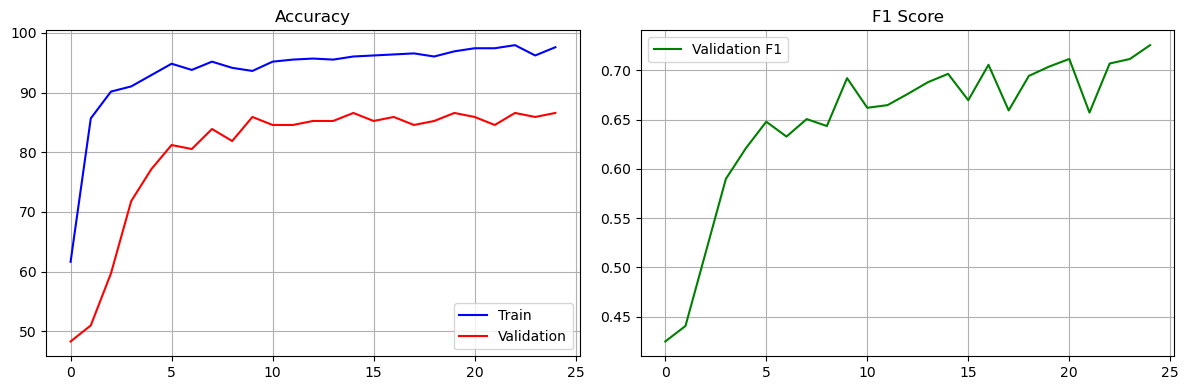

In [6]:
# Training configuration
optimizer = torch.optim.AdamW(
    model.classifier.parameters(), 
    lr=1e-4,  # Better learning rate
    weight_decay=0.01  # Moderate regularization
)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in tqdm(loader, leave=False, desc="Training"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        outputs = model(x)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    train_acc = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, train_acc

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(loader, leave=False, desc="Evaluating"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            preds = outputs.argmax(1).cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
    
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = 100. * sum([1 for t, p in zip(y_true, y_pred) if t == p]) / len(y_true)
    return f1, acc, classification_report(y_true, y_pred, target_names=families, digits=3)

# Training loop - no early stopping, run full epochs
best_f1 = 0
train_losses = []
train_accs = []
val_f1s = []
val_accs = []

print("Training started...")
print("=" * 50)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_f1, val_acc, report = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_f1s.append(val_f1)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{EPOCHS} | Loss: {train_loss:.4f} | "
          f"Train: {train_acc:5.1f}% | Val: {val_acc:5.1f}% | F1: {val_f1:.4f}", end="")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.classifier.state_dict(), PROJECT_ROOT / "best_model.pt")
        print(" [BEST]")
    else:
        print()
    
    if epoch % 5 == 0 and epoch > 0:
        print("-" * 50)
        print("Performance per class:")
        print(report)
        print("-" * 50)

print(f"\nTraining completed")
print(f"Best F1: {best_f1:.4f}")
print(f"Final Train: {train_accs[-1]:.1f}% | Final Val: {val_accs[-1]:.1f}%")

# Simple plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_accs, 'b-', label='Train')
ax1.plot(val_accs, 'r-', label='Validation')
ax1.set_title('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(val_f1s, 'g-', label='Validation F1')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Loading best model for testing...


TEST RESULTS
Test F1: 0.7339
Test Accuracy: 84.2%

Per-class performance:
              precision    recall  f1-score   support

   keyboards      0.808     0.955     0.875        44
  percussion      1.000     1.000     1.000        55
     strings      0.308     0.250     0.276        16
       voice      1.000     1.000     1.000        15
       winds      0.636     0.438     0.519        16

    accuracy                          0.842       146
   macro avg      0.750     0.728     0.734       146
weighted avg      0.826     0.842     0.830       146



Predictions: 100%|██████████| 37/37 [00:01<00:00, 25.90it/s]


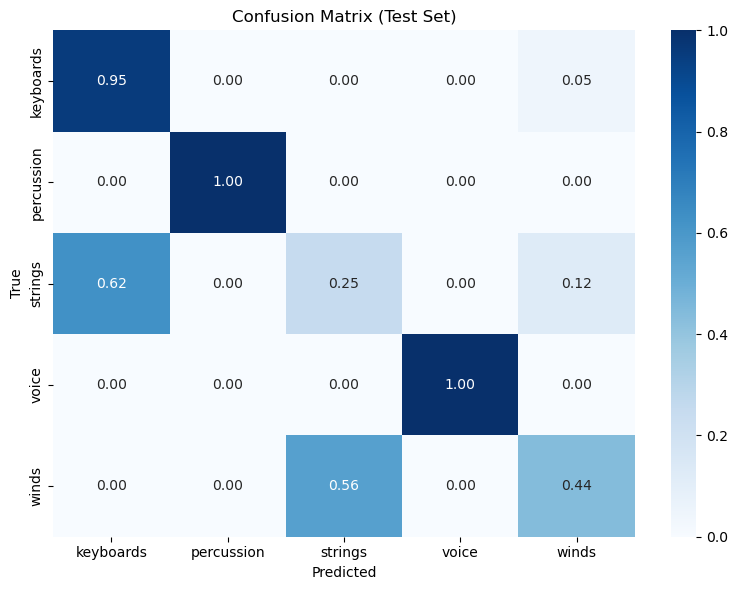

Training complete.


In [7]:
# Test evaluation
print("Loading best model for testing...")

model.classifier.load_state_dict(torch.load(PROJECT_ROOT / "best_model.pt", map_location=DEVICE))
model.to(DEVICE)

test_f1, test_acc, test_report = evaluate(model, test_loader)

print("=" * 50)
print("TEST RESULTS")
print("=" * 50)
print(f"Test F1: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.1f}%")
print("\nPer-class performance:")
print(test_report)

# Confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Predictions"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=families, yticklabels=families)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("Training complete.")